In [87]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from datetime import datetime

In [88]:
def get_transformed_data():
    print("Reading in and transforming data...")

    if not os.path.exists('Mnist/train.csv'):
        print('Looking for Mnist/train.csv')
        print('You have not downloaded the data and/or not placed the files in the correct location.')
        print('Please get the data from: https://www.kaggle.com/c/digit-recognizer')
        print('Place train.csv in the folder large_files adjacent to the class folder')
        exit()

    df = pd.read_csv('Mnist/train.csv')
    data = df.values.astype(np.float32)
    np.random.shuffle(data)

    X = data[:, 1:]
    Y = data[:, 0].astype(np.int32)

    Xtrain = X[:-1000]
    Ytrain = Y[:-1000]
    Xtest  = X[-1000:]
    Ytest  = Y[-1000:]

    # center the data
    mu = Xtrain.mean(axis=0)
    Xtrain = Xtrain - mu
    Xtest  = Xtest - mu

    # transform the data
    pca = PCA()
    Ztrain = pca.fit_transform(Xtrain)
    Ztest  = pca.transform(Xtest)
    # take first 300 cols of Z
    Ztrain = Ztrain[:, :300]
    Ztest = Ztest[:, :300]
    # normalize Z
    mu = Ztrain.mean(axis=0)
    std = Ztrain.std(axis=0)
    Ztrain = (Ztrain - mu) / std
    Ztest = (Ztest - mu) / std

    return Ztrain, Ztest, Ytrain, Ytest

In [89]:
def y2indicator(y):
    N = len(y)
    y = y.astype(np.int32)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [90]:
def gradW(t, y, X):
    return X.T.dot(t - y)

def gradb(t, y):
    return (t - y).sum(axis=0)

def cost(p_y, t):
    tot = t * np.log(p_y)
    return -tot.sum()
def predict(p_y):
    return np.argmax(p_y, axis=1)

def error_rate(p_y, t):
    prediction = predict(p_y)
    return np.mean(prediction != t)

In [91]:
def forward(X, W, b):
    # softmax
    a = X.dot(W) + b
    expa = np.exp(a)
    y = expa / expa.sum(axis=1, keepdims=True)
    return y

In [92]:
Xtrain,Xtest,Ytrain,Ytest = get_transformed_data()

Reading in and transforming data...


In [93]:
N,D = Xtrain.shape
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)
print(Ytest_ind.shape)

(1000, 10)


In [94]:
# Full Gradient Descent
W = np.random.randn(D,10) / 28
b = np.zeros(10)
LL = []
lr = 0.0001
reg = 0.01
t0 = datetime.now()
for i in range(50):
    p_y = forward(Xtrain, W, b)
    W += lr*(gradW(Ytrain_ind, p_y, Xtrain) - reg*W)
    b += lr*(gradb(Ytrain_ind, p_y) - reg*b)
    p_y_test = forward(Xtest, W, b)
    ll = cost(p_y_test, Ytest_ind)
    LL.append(ll)
    if i % 1 == 0:
        err = error_rate(p_y_test, Ytest)
        if i % 10 == 0:
            print("Cost at iteration %d: %.6f" % (i, ll))
            print("Error rate:", err)
p_y = forward(Xtest, W, b)
print("Final error rate:", error_rate(p_y, Ytest))
print("Elapsted time for full GD:", datetime.now() - t0)

Cost at iteration 0: 895.349279
Error rate: 0.177
Cost at iteration 10: 387.239402
Error rate: 0.097
Cost at iteration 20: 345.590366
Error rate: 0.094
Cost at iteration 30: 327.886066
Error rate: 0.091
Cost at iteration 40: 317.792488
Error rate: 0.092
Final error rate: 0.093
Elapsted time for full GD: 0:00:09.428551


In [95]:
# Stochastic Gradient Descent
W = np.random.randn(D, 10) / np.sqrt(D)
b = np.zeros(10)
LL_stochastic = []
lr = 0.0001
reg = 0.01

t0 = datetime.now()
for i in range(50): # takes very long since we're computing cost for 41k samples
    tmpX, tmpY = shuffle(Xtrain, Ytrain_ind)
    for n in range(min(N, 500)): # shortcut so it won't take so long...
        x = tmpX[n,:].reshape(1,D)
        y = tmpY[n,:].reshape(1,10)
        p_y = forward(x, W, b)

        W += lr*(gradW(y, p_y, x) - reg*W)
        b += lr*(gradb(y, p_y) - reg*b)

        p_y_test = forward(Xtest, W, b)
        ll = cost(p_y_test, Ytest_ind)
        LL_stochastic.append(ll)

    if i % 1 == 0:
        err = error_rate(p_y_test, Ytest)
        if i % 10 == 0:
            print("Cost at iteration %d: %.6f" % (i, ll))
            print("Error rate:", err)
p_y = forward(Xtest, W, b)
print("Final error rate:", error_rate(p_y, Ytest))
print("Elapsted time for SGD:", datetime.now() - t0)

Cost at iteration 0: 2754.104162
Error rate: 0.892
Cost at iteration 10: 2469.218996
Error rate: 0.842
Cost at iteration 20: 2213.878180
Error rate: 0.761
Cost at iteration 30: 1988.827439
Error rate: 0.674
Cost at iteration 40: 1795.554339
Error rate: 0.574
Final error rate: 0.487
Elapsted time for SGD: 0:01:11.310369


In [96]:
# batch Gradient Decent
W = np.random.randn(D, 10) / np.sqrt(D)
b = np.zeros(10)
LL_batch = []
lr = 0.0001
reg = 0.01
batch_sz = 500
n_batches = N // batch_sz

t0 = datetime.now()
for i in range(50):
    tmpX, tmpY = shuffle(Xtrain, Ytrain_ind)
    for j in range(n_batches):
        x = tmpX[j*batch_sz:(j*batch_sz + batch_sz),:]
        y = tmpY[j*batch_sz:(j*batch_sz + batch_sz),:]
        p_y = forward(x, W, b)

        W += lr*(gradW(y, p_y, x) - reg*W)
        b += lr*(gradb(y, p_y) - reg*b)

        p_y_test = forward(Xtest, W, b)
        ll = cost(p_y_test, Ytest_ind)
        LL_batch.append(ll)
    if i % 1 == 0:
        err = error_rate(p_y_test, Ytest)
        if i % 10 == 0:
            print("Cost at iteration %d: %.6f" % (i, ll))
            print("Error rate:", err)
p_y = forward(Xtest, W, b)
print("Final error rate:", error_rate(p_y, Ytest))
print("Elapsted time for batch GD:", datetime.now() - t0)

Cost at iteration 0: 1205.186768
Error rate: 0.287
Cost at iteration 10: 394.810540
Error rate: 0.094
Cost at iteration 20: 348.055770
Error rate: 0.093
Cost at iteration 30: 329.034073
Error rate: 0.091
Cost at iteration 40: 318.527751
Error rate: 0.092
Final error rate: 0.094
Elapsted time for batch GD: 0:00:29.382966


In [ ]:
# Momentum Gradient Descent

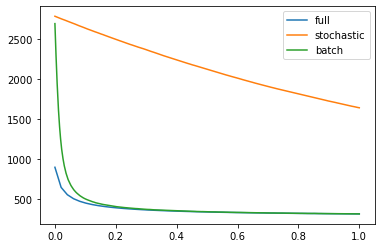

In [97]:
x1 = np.linspace(0, 1, len(LL))
plt.plot(x1, LL, label="full")
x2 = np.linspace(0, 1, len(LL_stochastic))
plt.plot(x2, LL_stochastic, label="stochastic")
x3 = np.linspace(0, 1, len(LL_batch))
plt.plot(x3, LL_batch, label="batch")
plt.legend()
plt.show()